In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    train_df_country = train_df_country.reset_index()
    
    return train_df_country

In [ ]:
def add_features(df, set_num):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        vc = data.loc[data['set'] == set_num, col].value_counts() / sum(data['set'] == set_num)
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Num of unique id: 569405
Num of train data: 11382870
Pos rate: 0.08688959814176916
           index                id point_of_interest          match_id  \
5212205     1385  E_0f429564a6da1a  P_f642d848e71335  E_7ec5ba47efeb5b   
4472776    27106  E_c86ddc821b79c6  P_849e76cc0fe457  E_df6dfe978b329c   
11057461  120996  E_fcf363be0d548b  P_ef33052ff36de1  E_ac498cc78efaed   
7248501     4393  E_2505e4d89b33fb  P_b87778ae16dcf7  E_d8444a6b83e207   
1467336     4457  E_8099364603ce96  P_52cf902c8bb877  E_8099364603ce96   

          kdist_country  kneighbors_country  label  
5212205        0.000418                   7      0  
4472776        0.001648                  18      0  
11057461       0.047233                  17      0  
7248501        0.000692                  10      0  
1467336        0.000000                   0      1  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9131152384242968


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,91.31%,8.69%
development set - fold 0,91.31%,8.69%
validation set - fold 0,91.31%,8.69%
development set - fold 1,91.31%,8.69%
validation set - fold 1,91.31%,8.69%
development set - fold 2,91.31%,8.69%
validation set - fold 2,91.31%,8.69%
development set - fold 3,91.31%,8.69%
validation set - fold 3,91.31%,8.69%
development set - fold 4,91.31%,8.69%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data, 0)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist_country','kneighbors_country']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

62
['kdist_country', 'kneighbors_country', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'categories_CE_2']


In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0489381
[100]	valid_0's binary_logloss: 0.0460549
[150]	valid_0's binary_logloss: 0.0448011
[200]	valid_0's binary_logloss: 0.0440428
[250]	valid_0's binary_logloss: 0.0434182
[300]	valid_0's binary_logloss: 0.0429616
[350]	valid_0's binary_logloss: 0.0425089
[400]	valid_0's binary_logloss: 0.0420908
[450]	valid_0's binary_logloss: 0.0417689
[500]	valid_0's binary_logloss: 0.0414155
[550]	valid_0's binary_logloss: 0.0411545
[600]	valid_0's binary_logloss: 0.0408783
[650]	valid_0's binary_logloss: 0.0406492
[700]	valid_0's binary_logloss: 0.0404455
[750]	valid_0's binary_logloss: 0.0402674
[800]	valid_0's binary_logloss: 0.0400474
[850]	valid_0's binary_logloss: 0.039831
[900]	valid_0's binary_logloss: 0.0396854
[950]	valid_0's binary_logloss: 0.0395458
[1000]	valid_0's binary_logloss: 0.0394051
[1050]	valid_0's binary_logloss: 0.0392363
[1100]	valid_0's binary_logloss: 0.0390318
[1150]	valid_0's binary_logloss: 0.0389064
[1200]	valid_0's binary_logloss:

In [ ]:
del train_data
gc.collect()

83

#Check Feature Importances

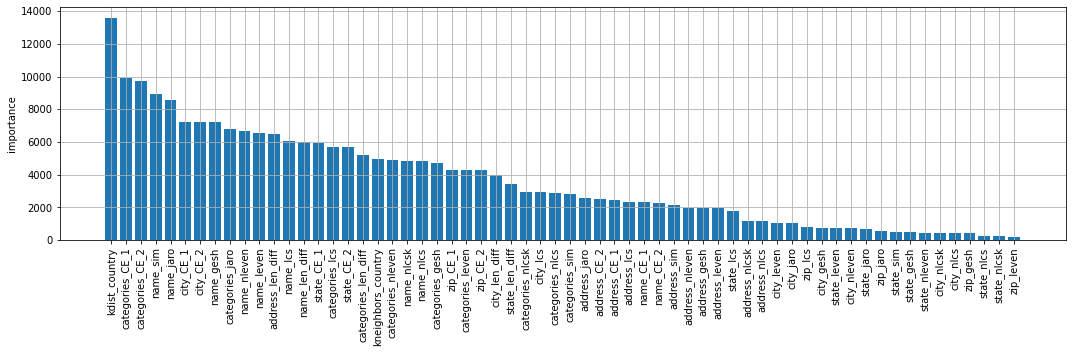

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data, 1)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-02 05:24:29,113] A new study created in memory with name: no-name-f5eb9d16-5205-4ae4-88d8-f0ae9bbffe4c
[I 2022-06-02 05:25:01,115] Trial 0 finished with value: 0.7839781999653489 and parameters: {'threshold': 0.9553263898295757}. Best is trial 0 with value: 0.7839781999653489.


CV: 0.783978


[I 2022-06-02 05:25:22,085] Trial 1 finished with value: 0.8166963133341802 and parameters: {'threshold': 0.2905126305672202}. Best is trial 1 with value: 0.8166963133341802.


CV: 0.816696


[I 2022-06-02 05:25:42,912] Trial 2 finished with value: 0.8270423338918038 and parameters: {'threshold': 0.6723636121238536}. Best is trial 2 with value: 0.8270423338918038.


CV: 0.827042


[I 2022-06-02 05:26:03,199] Trial 3 finished with value: 0.8255965733378805 and parameters: {'threshold': 0.42926045075359676}. Best is trial 2 with value: 0.8270423338918038.


CV: 0.825597


[I 2022-06-02 05:26:24,568] Trial 4 finished with value: 0.8177626482746765 and parameters: {'threshold': 0.30110226568630427}. Best is trial 2 with value: 0.8270423338918038.


CV: 0.817763


[I 2022-06-02 05:26:43,484] Trial 5 finished with value: 0.7745284824667329 and parameters: {'threshold': 0.9676393946183987}. Best is trial 2 with value: 0.8270423338918038.


CV: 0.774528


[I 2022-06-02 05:27:04,115] Trial 6 finished with value: 0.8218364314292703 and parameters: {'threshold': 0.77923026670833}. Best is trial 2 with value: 0.8270423338918038.


CV: 0.821836


[I 2022-06-02 05:27:36,941] Trial 7 finished with value: 0.8278645662052502 and parameters: {'threshold': 0.625187638689049}. Best is trial 7 with value: 0.8278645662052502.


CV: 0.827865


[I 2022-06-02 05:27:58,281] Trial 8 finished with value: 0.8281589167825659 and parameters: {'threshold': 0.5569903236200958}. Best is trial 8 with value: 0.8281589167825659.


CV: 0.828159


[I 2022-06-02 05:28:19,654] Trial 9 finished with value: 0.8268751424561723 and parameters: {'threshold': 0.46760060396771685}. Best is trial 8 with value: 0.8281589167825659.


CV: 0.826875


[I 2022-06-02 05:28:43,192] Trial 10 finished with value: 0.7154210824952324 and parameters: {'threshold': 0.033793454138223655}. Best is trial 8 with value: 0.8281589167825659.


CV: 0.715421


[I 2022-06-02 05:29:03,958] Trial 11 finished with value: 0.8266326743790589 and parameters: {'threshold': 0.6855869343778007}. Best is trial 8 with value: 0.8281589167825659.


CV: 0.826633


[I 2022-06-02 05:29:24,034] Trial 12 finished with value: 0.8277736577272791 and parameters: {'threshold': 0.6315916004178621}. Best is trial 8 with value: 0.8281589167825659.


CV: 0.827774


[I 2022-06-02 05:29:44,916] Trial 13 finished with value: 0.8281612663614932 and parameters: {'threshold': 0.5615321983909792}. Best is trial 13 with value: 0.8281612663614932.


CV: 0.828161


[I 2022-06-02 05:30:06,639] Trial 14 finished with value: 0.818086104735999 and parameters: {'threshold': 0.3049621444247779}. Best is trial 13 with value: 0.8281612663614932.


CV: 0.818086


[I 2022-06-02 05:30:26,698] Trial 15 finished with value: 0.8278630479129911 and parameters: {'threshold': 0.5127713052276663}. Best is trial 13 with value: 0.8281612663614932.


CV: 0.827863


[I 2022-06-02 05:30:47,081] Trial 16 finished with value: 0.8150854195090335 and parameters: {'threshold': 0.8483321771866841}. Best is trial 13 with value: 0.8281612663614932.


CV: 0.815085


[I 2022-06-02 05:31:09,014] Trial 17 finished with value: 0.7920543320652046 and parameters: {'threshold': 0.1435009711364008}. Best is trial 13 with value: 0.8281612663614932.


CV: 0.792054


[I 2022-06-02 05:31:29,297] Trial 18 finished with value: 0.8280924880021944 and parameters: {'threshold': 0.5343316682698578}. Best is trial 13 with value: 0.8281612663614932.


CV: 0.828092


[I 2022-06-02 05:31:50,554] Trial 19 finished with value: 0.8240037405453363 and parameters: {'threshold': 0.3920222802865896}. Best is trial 13 with value: 0.8281612663614932.


CV: 0.824004


[I 2022-06-02 05:32:12,001] Trial 20 finished with value: 0.8216444717615355 and parameters: {'threshold': 0.7823456385360973}. Best is trial 13 with value: 0.8281612663614932.


CV: 0.821644


[I 2022-06-02 05:32:32,774] Trial 21 finished with value: 0.8281634374792115 and parameters: {'threshold': 0.5581423881994104}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.828163


[I 2022-06-02 05:32:53,486] Trial 22 finished with value: 0.828158098249197 and parameters: {'threshold': 0.5618493654228585}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.828158


[I 2022-06-02 05:33:13,608] Trial 23 finished with value: 0.8237277619258191 and parameters: {'threshold': 0.3857808594061873}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.823728


[I 2022-06-02 05:33:34,523] Trial 24 finished with value: 0.8281458921581288 and parameters: {'threshold': 0.5759618705774107}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.828146


[I 2022-06-02 05:33:55,165] Trial 25 finished with value: 0.8244656698900908 and parameters: {'threshold': 0.7384630358296955}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.824466


[I 2022-06-02 05:34:15,186] Trial 26 finished with value: 0.8269465205922337 and parameters: {'threshold': 0.4702204689080881}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.826947


[I 2022-06-02 05:34:35,462] Trial 27 finished with value: 0.8126908526547095 and parameters: {'threshold': 0.8641190025088206}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.812691


[I 2022-06-02 05:34:56,140] Trial 28 finished with value: 0.8281612617276997 and parameters: {'threshold': 0.5990084637484111}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.828161


[I 2022-06-02 05:35:16,691] Trial 29 finished with value: 0.8257485442239388 and parameters: {'threshold': 0.7112967827369696}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.825749


[I 2022-06-02 05:35:38,262] Trial 30 finished with value: 0.8082212135461804 and parameters: {'threshold': 0.22166125652165936}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.808221


[I 2022-06-02 05:35:58,587] Trial 31 finished with value: 0.8281148181719612 and parameters: {'threshold': 0.582224728442335}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.828115


[I 2022-06-02 05:36:25,937] Trial 32 finished with value: 0.8277253995502905 and parameters: {'threshold': 0.6367920767912026}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.827725


[I 2022-06-02 05:36:47,221] Trial 33 finished with value: 0.8273803484903772 and parameters: {'threshold': 0.4862022363434573}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.827380


[I 2022-06-02 05:37:07,695] Trial 34 finished with value: 0.82372047510362 and parameters: {'threshold': 0.38628727510678385}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.823720


[I 2022-06-02 05:37:29,624] Trial 35 finished with value: 0.8281629428522252 and parameters: {'threshold': 0.6007721968162711}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.828163


[I 2022-06-02 05:37:58,271] Trial 36 finished with value: 0.8078242433007745 and parameters: {'threshold': 0.8898373332664573}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.807824


[I 2022-06-02 05:38:18,770] Trial 37 finished with value: 0.8232647349204345 and parameters: {'threshold': 0.7592066589681059}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.823265


[I 2022-06-02 05:38:39,340] Trial 38 finished with value: 0.827133867260164 and parameters: {'threshold': 0.6666140734935845}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.827134


[I 2022-06-02 05:39:00,427] Trial 39 finished with value: 0.8257602146661037 and parameters: {'threshold': 0.4324249934100901}. Best is trial 21 with value: 0.8281634374792115.


CV: 0.825760


[I 2022-06-02 05:39:22,158] Trial 40 finished with value: 0.8282104139617367 and parameters: {'threshold': 0.6036974445407053}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828210


[I 2022-06-02 05:39:42,580] Trial 41 finished with value: 0.8281328931822658 and parameters: {'threshold': 0.609290334524279}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828133


[I 2022-06-02 05:40:03,699] Trial 42 finished with value: 0.8281112398055924 and parameters: {'threshold': 0.5406308113068433}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828111


[I 2022-06-02 05:40:24,041] Trial 43 finished with value: 0.8271096638990225 and parameters: {'threshold': 0.6695165343667122}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827110


[I 2022-06-02 05:40:44,960] Trial 44 finished with value: 0.8281996354431306 and parameters: {'threshold': 0.6032917956547167}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828200


[I 2022-06-02 05:41:05,549] Trial 45 finished with value: 0.8195779741109933 and parameters: {'threshold': 0.8078695448075073}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.819578


[I 2022-06-02 05:41:25,915] Trial 46 finished with value: 0.8260185691517135 and parameters: {'threshold': 0.4409372746838843}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.826019


[I 2022-06-02 05:41:46,719] Trial 47 finished with value: 0.8254364463575798 and parameters: {'threshold': 0.7188578387995033}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.825436


[I 2022-06-02 05:42:07,734] Trial 48 finished with value: 0.8278311661865607 and parameters: {'threshold': 0.5112315616271563}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827831


[I 2022-06-02 05:42:28,844] Trial 49 finished with value: 0.8278730494590629 and parameters: {'threshold': 0.6243218112722563}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827873


[I 2022-06-02 05:42:48,828] Trial 50 finished with value: 0.8271890591401893 and parameters: {'threshold': 0.6647527986676952}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827189


[I 2022-06-02 05:43:09,775] Trial 51 finished with value: 0.8281674554297912 and parameters: {'threshold': 0.595459604114978}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828167


[I 2022-06-02 05:43:30,890] Trial 52 finished with value: 0.828080134028889 and parameters: {'threshold': 0.5339121481571212}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828080


[I 2022-06-02 05:43:51,997] Trial 53 finished with value: 0.8260324806090023 and parameters: {'threshold': 0.701954924887363}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.826032


[I 2022-06-02 05:44:13,669] Trial 54 finished with value: 0.8200030961030873 and parameters: {'threshold': 0.32934015503033476}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.820003


[I 2022-06-02 05:44:34,681] Trial 55 finished with value: 0.8281790952697808 and parameters: {'threshold': 0.5633019149676342}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828179


[I 2022-06-02 05:44:56,051] Trial 56 finished with value: 0.8274850690380915 and parameters: {'threshold': 0.4914294984515417}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827485


[I 2022-06-02 05:45:16,340] Trial 57 finished with value: 0.8277405939864757 and parameters: {'threshold': 0.6354537513823982}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827741


[I 2022-06-02 05:45:37,796] Trial 58 finished with value: 0.8281110670686358 and parameters: {'threshold': 0.5856514519428323}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828111


[I 2022-06-02 05:45:59,765] Trial 59 finished with value: 0.8279807623436253 and parameters: {'threshold': 0.5233891776325077}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827981


[I 2022-06-02 05:46:20,433] Trial 60 finished with value: 0.8263525162593444 and parameters: {'threshold': 0.4499261419542496}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.826353


[I 2022-06-02 05:46:42,014] Trial 61 finished with value: 0.8281694718322853 and parameters: {'threshold': 0.5577604733248703}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828169


[I 2022-06-02 05:47:02,214] Trial 62 finished with value: 0.8281581554409453 and parameters: {'threshold': 0.5572773108845153}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828158


[I 2022-06-02 05:47:23,087] Trial 63 finished with value: 0.8274681463032889 and parameters: {'threshold': 0.6521719095693939}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827468


[I 2022-06-02 05:47:44,432] Trial 64 finished with value: 0.8281585590126646 and parameters: {'threshold': 0.5999146896998089}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828159


[I 2022-06-02 05:48:04,478] Trial 65 finished with value: 0.8281635116238808 and parameters: {'threshold': 0.5649677766249823}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828164


[I 2022-06-02 05:48:35,323] Trial 66 finished with value: 0.5799672291394941 and parameters: {'threshold': 0.006095373034898155}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.579967


[I 2022-06-02 05:48:56,401] Trial 67 finished with value: 0.8276092559469067 and parameters: {'threshold': 0.5002912845530427}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827609


[I 2022-06-02 05:49:16,628] Trial 68 finished with value: 0.828161768146342 and parameters: {'threshold': 0.5615301632535996}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828162


[I 2022-06-02 05:49:38,113] Trial 69 finished with value: 0.8245322849914336 and parameters: {'threshold': 0.40183470230520313}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.824532


[I 2022-06-02 05:49:58,326] Trial 70 finished with value: 0.8281157449349104 and parameters: {'threshold': 0.5398456301671437}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828116


[I 2022-06-02 05:50:19,152] Trial 71 finished with value: 0.8281028273947262 and parameters: {'threshold': 0.6116856363133885}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828103


[I 2022-06-02 05:50:40,260] Trial 72 finished with value: 0.8270353306245595 and parameters: {'threshold': 0.4729588353882104}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827035


[I 2022-06-02 05:51:01,281] Trial 73 finished with value: 0.8281046483072119 and parameters: {'threshold': 0.5853494799492023}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828105


[I 2022-06-02 05:51:21,428] Trial 74 finished with value: 0.8263959529627734 and parameters: {'threshold': 0.6939037831700319}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.826396


[I 2022-06-02 05:51:42,477] Trial 75 finished with value: 0.8276706356757257 and parameters: {'threshold': 0.6392200081944026}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827671


[I 2022-06-02 05:52:02,386] Trial 76 finished with value: 0.8281343918205007 and parameters: {'threshold': 0.5706805355839074}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828134


[I 2022-06-02 05:52:23,251] Trial 77 finished with value: 0.8278591090805626 and parameters: {'threshold': 0.515000127521497}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827859


[I 2022-06-02 05:52:44,617] Trial 78 finished with value: 0.8246253873708488 and parameters: {'threshold': 0.7355931448397192}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.824625


[I 2022-06-02 05:53:05,651] Trial 79 finished with value: 0.8280997614007409 and parameters: {'threshold': 0.6111354424340587}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828100


[I 2022-06-02 05:53:26,081] Trial 80 finished with value: 0.8265586886091884 and parameters: {'threshold': 0.6882442826744484}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.826559


[I 2022-06-02 05:53:47,730] Trial 81 finished with value: 0.8281694718322853 and parameters: {'threshold': 0.5577565224825964}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828169


[I 2022-06-02 05:54:09,443] Trial 82 finished with value: 0.8281589241188599 and parameters: {'threshold': 0.5510201788810826}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828159


[I 2022-06-02 05:54:30,419] Trial 83 finished with value: 0.828157759826046 and parameters: {'threshold': 0.5910511624471251}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828158


[I 2022-06-02 05:54:50,797] Trial 84 finished with value: 0.8266469426182919 and parameters: {'threshold': 0.4604995106306177}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.826647


[I 2022-06-02 05:55:11,647] Trial 85 finished with value: 0.827465131197571 and parameters: {'threshold': 0.6516233974969673}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827465


[I 2022-06-02 05:55:33,002] Trial 86 finished with value: 0.8275622602050469 and parameters: {'threshold': 0.49624784799915966}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827562


[I 2022-06-02 05:55:54,413] Trial 87 finished with value: 0.8279120235977565 and parameters: {'threshold': 0.6217223517939959}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827912


[I 2022-06-02 05:56:15,707] Trial 88 finished with value: 0.8280291739195815 and parameters: {'threshold': 0.528453320059863}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828029


[I 2022-06-02 05:56:36,613] Trial 89 finished with value: 0.8281371313254219 and parameters: {'threshold': 0.5697226386962745}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828137


[I 2022-06-02 05:56:58,846] Trial 90 finished with value: 0.7915038800800231 and parameters: {'threshold': 0.14171501653353896}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.791504


[I 2022-06-02 05:57:19,987] Trial 91 finished with value: 0.8281550969720816 and parameters: {'threshold': 0.5569094572057753}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828155


[I 2022-06-02 05:57:39,937] Trial 92 finished with value: 0.8281425620420039 and parameters: {'threshold': 0.5896976707359852}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828143


[I 2022-06-02 05:58:00,860] Trial 93 finished with value: 0.8281746151145211 and parameters: {'threshold': 0.5444227114813043}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828175


[I 2022-06-02 05:58:20,795] Trial 94 finished with value: 0.8279152870179917 and parameters: {'threshold': 0.5189307881810058}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827915


[I 2022-06-02 05:58:41,719] Trial 95 finished with value: 0.8271389450546932 and parameters: {'threshold': 0.47691024433074725}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827139


[I 2022-06-02 05:59:02,803] Trial 96 finished with value: 0.8251294950065042 and parameters: {'threshold': 0.41763141650592084}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.825129


[I 2022-06-02 05:59:23,686] Trial 97 finished with value: 0.8270522277581697 and parameters: {'threshold': 0.6711904208497689}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827052


[I 2022-06-02 05:59:43,583] Trial 98 finished with value: 0.8277983805366983 and parameters: {'threshold': 0.6300975344304776}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.827798


[I 2022-06-02 06:00:04,408] Trial 99 finished with value: 0.8281128061812741 and parameters: {'threshold': 0.5409751890806301}. Best is trial 40 with value: 0.8282104139617367.


CV: 0.828113


In [ ]:
threshold = study.best_params['threshold']
threshold

0.6036974445407053

In [ ]:
study.best_value

0.8282104139617367

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.828210


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,index,kdist_country,kneighbors_country,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,139323.000000,139323.000000,139323.000000,139323.0,139323.000000,139323.000000,139323.000000,139323.000000,139323.000000,139323.000000,...,105160.000000,105160.000000,105160.000000,119076.000000,119481.000000,139323.000000,105160.000000,105160.000000,105160.000000,1.393230e+05
mean,21438.120956,0.003457,6.203075,1.0,0.267751,0.410558,16.542287,0.575459,8.562922,0.000029,...,12.276807,0.680318,9.049163,0.004923,0.004921,8.966703,0.529709,0.587695,0.588577,2.052589e-01
std,23454.120903,0.022948,5.226542,0.0,0.299300,0.249777,9.414975,0.227961,6.484759,0.000287,...,11.496220,0.243651,7.229667,0.005906,0.005900,10.877758,0.354828,0.330533,0.330359,1.891983e-01
min,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,6.951282e-10
25%,4199.000000,0.000329,2.000000,1.0,0.000000,0.206897,10.000000,0.449495,4.000000,0.000002,...,0.000000,0.484127,4.000000,0.000717,0.000710,0.000000,0.000000,0.285714,0.285714,3.063909e-02
50%,14325.000000,0.000843,4.000000,1.0,0.179131,0.400000,15.000000,0.566794,7.000000,0.000002,...,11.000000,0.589286,7.000000,0.002541,0.002531,6.000000,0.714286,0.500000,0.500000,1.478967e-01
75%,29294.000000,0.002324,10.000000,1.0,0.498031,0.592593,22.000000,0.710526,12.000000,0.000002,...,17.000000,1.000000,12.000000,0.006273,0.006273,13.000000,0.818182,1.000000,1.000000,3.594338e-01
max,122765.000000,2.388985,19.000000,1.0,1.000000,1.000000,59.000000,1.000000,58.000000,0.004961,...,87.000000,1.000000,63.000000,0.022032,0.022032,90.000000,1.000000,1.000000,1.000000,6.036949e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,index,id,point_of_interest,match_id,kdist_country,kneighbors_country,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
7686628,15304,E_44ab91f8ce98c0,P_0238e600afa73b,E_a34f8e62489158,0.000312,2,1,0.000000,0.588235,11.0,...,15.0,0.542424,6.0,0.001918,0.010302,9,0.750000,0.300000,0.545455,0.155851
10211219,14961,E_1f3519eba4ff0c,P_6598a50a859a53,E_279bb0cc5349d4,0.011997,11,1,0.000000,0.444444,13.0,...,31.0,0.571047,13.0,0.004424,0.000581,27,0.704545,0.295455,0.764706,0.236663
6655038,5091,E_f4732eba96c2fb,P_4619891f6436c6,E_996c890e699af3,0.002088,11,1,0.000000,0.260870,25.0,...,NaN,NaN,NaN,0.002179,NaN,4,NaN,NaN,NaN,0.017221
7320484,5770,E_31643161d6ff2b,P_5586b57b5eded6,E_4f99ff62a4f437,0.000094,12,1,0.000000,0.333333,34.0,...,57.0,0.455009,5.0,0.000002,0.000102,51,0.934426,0.500000,0.081967,0.470412
8534205,6771,E_1e158880d8b37f,P_5ad22ec479a1e1,E_366fa31d7f6112,0.000472,17,1,0.242646,0.551724,10.0,...,NaN,NaN,NaN,0.008764,NaN,18,NaN,NaN,NaN,0.091126
3857061,6500,E_2f8edd92859bd8,P_2801e83be28333,E_736255ad061441,0.000007,1,1,0.000000,0.761905,5.0,...,14.0,0.473203,5.0,0.001756,0.001063,2,0.823529,0.333333,0.294118,0.327682
6103790,23679,E_d4eb54d370319b,P_05cdd1809fb8e9,E_01f3b7ef3a6a29,0.000432,2,1,0.000000,0.222222,15.0,...,19.0,0.556508,7.0,0.000969,0.000676,11,0.760000,0.280000,0.500000,0.084902
4867203,7819,E_b8a60a641ec16b,P_00f55a194cc645,E_9b21304df83b88,0.000342,1,1,0.542234,0.754717,9.0,...,31.0,0.496947,9.0,0.000562,0.000002,18,0.794872,0.230769,0.428571,0.353534
6345179,9396,E_53eda87144aefb,P_e6eaeae67f4b4b,E_4cf61e081f734c,0.003613,11,1,0.000000,0.166667,21.0,...,NaN,NaN,NaN,0.000462,NaN,8,NaN,NaN,NaN,0.017586
8063998,50230,E_e093f0a16236e6,P_b2042d7956be76,E_f8d5a413d9bded,0.002885,8,1,0.403112,0.648649,11.0,...,9.0,0.857353,8.0,0.002250,0.001544,9,0.529412,0.470588,1.000000,0.113228


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
205808,E_2e311a3fe00371,Brunei International Airport,-41.036766,88.58379,NaN,NaN,NaN,NaN,XX,NaN,NaN,Airports,P_967c383feaeb46,4,1.0
349459,E_4e881ed5f9346c,♦Jm's cafe♦,-41.000110,88.59306,NaN,NaN,NaN,NaN,XX,NaN,NaN,"Buildings, Fast Food Restaurants, Cafés",P_967c383feaeb46,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
103206,E_17222b2d6fb6ef,cinescape avenues,29.302498,47.932117,NaN,NaN,NaN,NaN,KW,NaN,NaN,Shopping Malls,P_83eed185691247,4,1.0
352638,E_4f3d3446173c17,First Round Avenue,29.302555,47.933098,NaN,NaN,NaN,NaN,KW,NaN,NaN,Antique Shops,P_83eed185691247,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
928579,E_d0956e909aadc8,Cascade Towing,47.170601,-122.169349,19425 State Route 410 E,Bonney Lake,WA,98391,US,NaN,+12538621210,"Transportation Services, Construction & Landsc...",P_8d1d2174adcbe3,1,1.0
990691,E_de8d631db2b8d3,Cascade Eye & Skin Centers,47.165206,-122.160119,10004 204th Ave E 1500,Bonney Lake,WA,98391,US,https://www.cascadeeyeskin.com,+12538483000,Hospitals,P_8d1d2174adcbe3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
7860,E_01c960bd053ee7,Sacramento do Chiado,38.711543,-9.140402,"Calçada do Sacramento, 40 - 46",Lisboa,Lisboa,1200-394,PT,http://www.sacramentodochiado.com/,NaN,"Portuguese Restaurants, Cocktail Bars",P_27f65a144e3c50,2,1.0
331770,E_4a92c27f94e376,Sacremento Restaurant,38.711859,-9.139985,NaN,Lisboa,Lisbonne,1200,PT,NaN,NaN,Restaurants,P_27f65a144e3c50,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
18938,E_04415f99096c43,Oceans27 Beach Club & Grill,-8.727558,115.167204,Jl. Kartika Plaza,"Denpasar, Bali",NaN,NaN,ID,NaN,NaN,Restaurants,P_ba05109e1ee374,3,1.0
472925,E_6a49938c9f9d15,27ocean,-8.727400,115.167388,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ba05109e1ee374,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
81426,E_12361bbf098a59,tavuk dünyası,39.657421,27.906501,NaN,NaN,NaN,NaN,TR,NaN,NaN,Fried Chicken Joints,P_116688cd502103,2,1.0
325580,E_49338d75de591c,Yay/Ada Tavuk Dünyası,39.657386,27.906652,NaN,NaN,NaN,NaN,TR,NaN,NaN,Turkish Restaurants,P_116688cd502103,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
548024,E_7b2b6c096f03e0,JW Lap Pool,33.845810,-84.359808,NaN,Atlanta,GA,NaN,US,NaN,NaN,Pools,P_b0d9ec77c4c0bb,2,1.0
879584,E_c591679af90952,JW Marriott Room 1404,33.845736,-84.359280,NaN,Atlanta,GA,NaN,US,NaN,NaN,Hotels,P_b0d9ec77c4c0bb,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
370867,E_535879ef3b54d3,Altaş Yağ Sanayii Operasyon Binası,40.985218,37.926193,Durugöl Mah.,Ordu,Ordu,52200,TR,NaN,NaN,Factories,P_5b50e6858ce248,3,1.0
420513,E_5e79b7ea4e36fe,Altaş Yağ Fabrikası,40.983557,37.927542,NaN,Ordu,NaN,NaN,TR,NaN,NaN,"Factories, Business Centers",P_5b50e6858ce248,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
110760,E_18d087fb17e3f3,Asosiasi Pilot Garuda,-6.130570,106.647205,Pilot House Garuda Operations Centre,Jakarta,Jakarta,19130,ID,NaN,NaN,"Offices, Airport Lounges",P_7604faa0271579,1,1.0
795388,E_b2a23af13e8cff,Pilot House (APG),-6.130527,106.646014,Garuda Indonesia Sentra Operasi,"Tangerang, Banten",Banten,NaN,ID,http://www.apg.or.id,NaN,"Airport Lounges, Offices",P_7604faa0271579,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
150116,E_21a7dd81685f8b,หนึ่ง อาหารทะเลสด,12.644659,101.632501,NaN,Kram,Rayong,NaN,TH,NaN,NaN,NaN,P_9b950706a59088,3,1.0
363065,E_51942723e8bd3a,น้องหนึ่งซีฟู๊ด (Nong Neung Seafood),12.644408,101.632497,Lam Mae Pim Beach,Rayong,Bangkok,NaN,TH,NaN,0892288225,Seafood Restaurants,P_9b950706a59088,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
501440,E_70be5adf373cbd,"""Warung Super Madura \""Pak Sabar\""""",-7.961901,112.625822,NaN,NaN,NaN,NaN,ID,NaN,NaN,Asian Restaurants,P_c2a75c929a841a,4,1.0
938520,E_d2cd618066fd97,"""Warung Sate Maknyus \""P Sabar\""""",-7.961845,112.625851,NaN,Malang,East Java,NaN,ID,NaN,NaN,"Mediterranean Restaurants, Fast Food Restaurants",P_c2a75c929a841a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
20151,E_04852c224633d4,"探索_想买个原单lv服装货源直供,在哪里买玩",38.413248,-95.925751,wb潺，高仿▊选款溦商呺 ↘ 1143 88б8↙▊原版超一仿高精仿法国的买家奢侈品包包围巾...,探索_,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_bb53ce072cad10,4,1.0
524580,E_75dfa4b4f941b6,"探索 - 微信买揭秘一下奢侈品lv服装,怎么样出",38.413248,-95.925751,nn淡，高仿▊选款溦商呺 ↘ 1143 88б8↙▊原版超一仿高精仿法国的买家奢侈品包包围巾...,探索 -,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_bb53ce072cad10,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
223389,E_322928ac1093cf,SGS Cartagena,10.405129,-75.523536,NaN,NaN,NaN,NaN,CO,NaN,NaN,Offices,P_a42d30eebd2ef0,3,1.0
440193,E_62ee2eabf4d618,DENTISALUD CARTAGENA,10.415317,-75.529675,CARIBE PLAZA CENTRO COMERCIAL LOCAL 001 PIE DE...,Cartagena,NaN,NaN,CO,NaN,NaN,Dentist's Offices,P_a42d30eebd2ef0,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
123984,E_1bcb4d55dd27e8,Alaan Art Space,24.709081,46.665237,NaN,NaN,NaN,NaN,SA,NaN,NaN,NaN,P_9a151d1bed8693,2,1.0
431662,E_6105038a8ecafd,Alāan | الآن,24.709268,46.666444,280 Orouba Rd.,Riyadh,Riyadh,280,SA,http://alaanart.com,114169550,"French Restaurants, Art Galleries, Cafés",P_9a151d1bed8693,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
287493,E_408c7440d208c4,Acibadem Maslak Jinekoloji,41.126870,29.024744,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_d5a67f354ffadc,4,1.0
1091585,E_f552cbdd43986f,Acibadem Maslak Koroner Yogun Bakim,41.127681,29.025072,NaN,NaN,NaN,NaN,TR,NaN,NaN,Medical Centers,P_d5a67f354ffadc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
52194,E_0bb0006a29fd02,Obyek wisata Pabrik Gula Sondokoro,-7.574704,110.887013,Karanganyar,Solo,NaN,NaN,ID,NaN,NaN,General Entertainment,P_4baaee99939aaf,3,1.0
1027885,E_e6f15c95c61711,Agrowisata Sondokoro,-7.575521,110.931144,Tasikmadu,Karanganyar,Jawa Tengah,57761,ID,http://agrowisata-sondokoro.blogspot.com,2717009334,"Other Great Outdoors, Gardens, Theme Parks",P_4baaee99939aaf,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
88577,E_13da6a6d0335ab,у Валерии Владимировны👌,56.136596,47.243732,NaN,NaN,NaN,NaN,RU,NaN,NaN,Student Centers,P_34c4f8aeaeda76,4,1.0
174665,E_272d6495be11f1,У Директора В Приемной,56.137252,47.243611,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_34c4f8aeaeda76,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
107331,E_180f8680c423d4,Matematiikan Luokka,60.266124,24.851289,NaN,NaN,NaN,NaN,FI,NaN,NaN,College Classrooms,P_d3c728d20f7a17,4,1.0
462138,E_67d30926c0ccc5,English Class 167 ,60.266661,24.851617,NaN,NaN,NaN,NaN,FI,NaN,NaN,College Classrooms,P_d3c728d20f7a17,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
127721,E_1ca09301bf68a1,สถาบันการบินพลเรือน@ศูนย์ฝึกบินหัวหิน,12.630543,99.951580,NaN,NaN,NaN,NaN,TH,NaN,NaN,"College Academic Buildings, Offices",P_33665d47373b93,1,1.0
917832,E_ce2ae1d55eb572,Civil Aviation Training Center (CATC),12.630788,99.951444,NaN,Hua Hin,Prachuap Khiri Khan,NaN,TH,NaN,NaN,Flight Schools,P_33665d47373b93,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
686992,E_9a4a9b00d86685,Akşehir Kirazlı Bahçe,38.501107,31.267803,NaN,NaN,NaN,NaN,TR,NaN,NaN,Farms,P_110dc6a01f6f9f,4,1.0
968674,E_d998d5592db92d,KİRAZLIBAHÇE,38.493675,31.272460,NaN,NaN,NaN,NaN,TR,NaN,NaN,Recreation Centers,P_110dc6a01f6f9f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
56115,E_0c915ec9605383,Fenerbahçe SK Topuk Yaylası Tesisleri Toplantı...,40.690540,31.363622,NaN,NaN,NaN,NaN,TR,NaN,NaN,Meeting Rooms,P_be418253275fc9,4,1.0
130005,E_1d249b20a6e44f,Fenerbahçe SK Serkan Acar Tesisleri,40.690515,31.364143,Kaynaşlı,Düzce,Türkiye,NaN,TR,http://t.co/8WTSubPaPN,3805477077,"Rest Areas, Athletics & Sports",P_be418253275fc9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
532322,E_77a1c09242525f,Özgür Teras,38.333681,41.419464,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_29a15354c8c394,4,1.0
1096869,E_f68580facc92c2,Malaşerro Aşiret Bölgesi,38.333980,41.420358,NaN,NaN,NaN,NaN,TR,NaN,NaN,Plazas,P_29a15354c8c394,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
756227,E_a9e1aa7bcef320,Greene Turtle Apparel,38.418750,-75.056663,NaN,Ocean City,MD,21842,US,NaN,NaN,Clothing Stores,P_ad6ae9dafa3e78,1,1.0
873722,E_c440ee612eca66,The Greene Turtle,38.421751,-75.056853,11601 Coastal Hwy,Ocean City,MD,21842,US,https://originalgreeneturtle.com,+14107232120,"Sports Bars, American Restaurants, Seafood Res...",P_ad6ae9dafa3e78,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
469858,E_699990c31e0520,Mimar Sinan Güzel Sanatlar Üniversitesi,41.029919,28.989017,Beyoğlu,İstanbul,NaN,NaN,TR,NaN,NaN,Universities,P_87f89fc6f45dba,3,1.0
807186,E_b5440daf279e35,MSGSU,41.030033,28.988155,NaN,Istanbul,NaN,NaN,TR,NaN,NaN,NaN,P_87f89fc6f45dba,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
471378,E_69f119648d865c,Взлетно-посадочная полоса / Runway,56.179614,92.481329,Аэропорт Емельяново,Красноярск,Красноярский край,663021,RU,http://www.yemelyanovo.ru,NaN,Airport Services,P_a2652048353664,2,1.0
1133573,E_fecd5c9c7e84e6,Стоянка 28,56.181344,92.473368,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_a2652048353664,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
301720,E_43c02624690ea0,happy hour sebastian beach by hande yener,37.101612,27.282423,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Nightlife,P_f24c68a56429b3,4,1.0
601483,E_872def7d211c68,Sebastian Beach Club,37.103516,27.286886,NaN,Yalıkavak,Muğla,48400,TR,NaN,NaN,Beaches,P_f24c68a56429b3,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
197573,E_2c5597c17c1722,Nasi Kucing Kawan Lama,-6.191070,106.743641,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_90d91177bf4fa0,1,1.0
249164,E_37ee04c8371108,Taman Puring,-6.191189,106.744021,Jl. Gandaria,Jakarta,Jakarta,15154,ID,NaN,02199147441,"Accessories Stores, Clothing Stores, Plazas",P_90d91177bf4fa0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
210335,E_2f37796f9715f1,Tour Eiffel,48.85824,2.294531,NaN,Paris,Île-de-France,75007,FR,NaN,NaN,Tour Providers,P_f82d146eaf21da,4,1.0
902499,E_cab60f8ce907e5,Ейфелева Вежа,48.85832,2.294411,NaN,Париж,Іль-де-Франс,75007,FR,NaN,NaN,Historic Sites,P_f82d146eaf21da,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
184533,E_2966aeb5ef24b7,Kampus Unika Delasalle,1.504966,124.872722,Kombos,Manado,Sulawesi Utara,NaN,ID,NaN,NaN,Universities,P_5653f981f925de,4,1.0
873694,E_c43ef6741b06a0,Universitas Katolik De La Salle Manado,1.504957,124.872701,Kairagi 1 Kombos Manado,Manado,Indonesia,NaN,ID,NaN,NaN,Universities,P_5653f981f925de,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
976545,E_db5eea919e176c,Ağrı Dağı’n Eteğin’deee,39.545032,44.094189,NaN,NaN,NaN,NaN,TR,NaN,NaN,Breweries,P_ebc98b161048ec,4,1.0
979937,E_dc22257ecfd7f3,agri dagi,39.557675,44.089117,NaN,NaN,NaN,NaN,TR,NaN,NaN,Event Spaces,P_ebc98b161048ec,4,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,index,kdist_country,kneighbors_country,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,47930.000000,47930.000000,47930.000000,47930.0,47930.000000,47906.000000,47906.000000,47906.000000,47906.000000,47911.000000,...,35855.000000,35855.000000,35855.000000,41121.000000,39998.000000,47930.000000,35855.000000,35855.000000,35855.000000,47930.000000
mean,22971.531004,0.002608,4.855518,0.0,0.498872,0.586693,12.954786,0.717007,11.617751,0.000053,...,10.157468,0.785867,11.521601,0.004641,0.004603,8.973774,0.374180,0.739541,0.739413,0.811716
std,25391.507427,0.011680,4.963441,0.0,0.341372,0.260053,9.639068,0.224144,7.191269,0.000379,...,12.403139,0.238679,7.896604,0.005621,0.005573,11.958426,0.364229,0.323543,0.323593,0.120882
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.603699
25%,4009.250000,0.000239,1.000000,0.0,0.211099,0.400000,6.000000,0.563937,6.000000,0.000002,...,0.000000,0.543074,6.000000,0.000485,0.000493,0.000000,0.000000,0.416667,0.418393,0.704717
50%,14480.000000,0.000660,3.000000,0.0,0.535931,0.600000,12.000000,0.743934,10.000000,0.000002,...,7.000000,0.889474,11.000000,0.002432,0.002439,4.000000,0.411765,1.000000,1.000000,0.813679
75%,33744.250000,0.001929,7.000000,0.0,0.772949,0.787879,18.000000,0.901016,16.000000,0.000002,...,17.000000,1.000000,15.000000,0.006361,0.006273,14.000000,0.750000,1.000000,1.000000,0.922649
max,122734.000000,0.646938,19.000000,0.0,1.000000,1.000000,56.000000,1.000000,55.000000,0.004961,...,109.000000,1.000000,93.000000,0.022032,0.022032,106.000000,1.000000,1.000000,1.000000,0.999998


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,index,id,point_of_interest,match_id,kdist_country,kneighbors_country,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
7619900,5650,E_18fb8f629240ce,P_a834e7e849975c,E_108f1c44827d66,0.000100,1,0,0.387980,0.571429,9.0,...,13.0,0.718687,20.0,0.010302,0.000165,13,0.393939,0.606061,1.000000,0.661983
792709,15447,E_98b8cfc40aef89,P_d1a9182d5e4ae1,E_3cae760c049b10,0.036140,10,0,0.902632,0.820513,7.0,...,13.0,0.486772,6.0,0.001468,0.011670,4,0.722222,0.333333,0.428571,0.686639
4722166,66,E_08f5ec206a89d1,P_8216393a5d48f7,E_b6a0490124dff1,0.000357,1,0,0.222582,0.461538,20.0,...,0.0,1.000000,16.0,0.000495,0.000495,0,0.000000,1.000000,1.000000,0.741738
8578998,51564,E_e6cd343494063f,P_cd6381d7422053,E_e356702f336090,0.000785,17,0,0.000000,0.444444,26.0,...,NaN,NaN,NaN,0.002947,NaN,20,NaN,NaN,NaN,0.807837
3325887,23573,E_6cad8d9248af38,P_554a3b72530a2a,E_924d7de5c2ae56,0.001070,15,0,0.151586,0.150943,30.0,...,0.0,1.000000,5.0,0.018813,0.018813,0,0.000000,1.000000,1.000000,0.636890
1061542,1522,E_40b54f48c1dd33,P_c6a1bca178a900,E_91303e69ae4e51,0.000076,1,0,1.000000,1.000000,0.0,...,0.0,1.000000,38.0,0.001640,0.001640,0,0.000000,1.000000,1.000000,0.890389
3049394,23595,E_6cc4f3765ee7b6,P_f394cea16e0959,E_2eb24b1bd04bfa,0.001957,10,0,0.000000,0.350000,18.0,...,NaN,NaN,NaN,0.001366,NaN,10,NaN,NaN,NaN,0.986403
2964163,48970,E_e2ad37f2efff98,P_fd9633ce96b054,E_c72095c93c1557,0.000161,8,0,0.577195,0.633333,12.0,...,NaN,NaN,NaN,NaN,0.000299,10,NaN,NaN,NaN,0.775714
2542590,14518,E_42a77ed6f4eaa2,P_622a8b9d115656,E_0daa8884d0c1c3,0.002161,1,0,0.403942,0.585366,14.0,...,21.0,0.582621,18.0,0.018778,0.000002,21,0.538462,0.461538,1.000000,0.887544
3919482,33665,E_f3d928d6e1afd9,P_91ad19e8bb0b57,E_c7124b89cc1829,0.000159,2,0,0.717757,0.666667,6.0,...,17.0,0.543478,6.0,0.000002,0.002531,17,0.739130,1.000000,0.260870,0.809454


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
527104,E_7671b5295aa58c,"Giffarine, กิฟฟารีน ศรีราชา",13.167927,100.927343,Sriracha Nakorn,Si Racha,Chon Buri,NaN,TH,NaN,NaN,Cosmetics Shops,P_27f21e0fac2b3c,0,1.0
1018014,E_e4b6a1da806c32,คลินิก ฟ.ฟัน ศรีราชา,13.167623,100.927382,ตรงข้ามเว็บไซต์เก่า,ศรีราชา,ชลบุรี,20110,TH,NaN,NaN,NaN,P_4ace111a384408,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
39222,E_08cc9f3af4f423,Dalston Hall Hotel,54.855183,-2.972388,NaN,NaN,NaN,NaN,GB,NaN,NaN,Bed & Breakfasts,P_fde1647c01476e,0,1.0
51293,E_0b7bb337db1622,Dalston Hall Golf Club,54.855026,-2.972203,Dalston,Carlisle,Cumbria,CA5 7JX,GB,NaN,NaN,Golf Courses,P_489c89ae421abe,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
490584,E_6e490939d84ac8,S Springpfuhl,52.526643,13.536734,Märkische Allee,Berlin,Berlin,12681,DE,http://www.bahnhof.de,+491805996633,Light Rail Stations,P_d86150ae251807,0,1.0
1038172,E_e9400a37c6fb3f,H S Springpfuhl,52.525641,13.535199,Allee der Kosmonauten,Berlin,Berlin,12681,DE,http://www.bvg.de,+493019449,"Tram Stations, Bus Stops, Light Rail Stations",P_c4b77fe80be576,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
28779,E_0673d52a4527ce,Jeugdverblijfcentrum Radar Afrit 9,51.005934,3.171603,Gentweg,Lichtervelde,NaN,8820,BE,http://www.radar9.be,NaN,Boarding Houses,P_905b32241c3ea9,0,1.0
852047,E_bf5a723e7f040b,Radar Afrit 9,51.005452,3.170950,Gentweg,Lichtervelde,NaN,8810,BE,http://www.radar9.be,51725449,"Campgrounds, Boarding Houses",P_36583d7031885c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
310504,E_45c0a050b50ffe,Chef's kitchen,-6.258910,106.815335,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_21fcf1f6c459c4,1,1.0
552926,E_7c47dcf9fe2ee7,Lulo Kitchen & Bar,-6.259775,106.815317,"Kemang Arcade, Ground Floor",Jakarta Selatan,DKI Jakarta,12730,ID,NaN,217182302,"Cocktail Bars, American Restaurants",P_073d7e2647e601,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
368951,E_52e1f8dda8ab05,Giant Fatmawati,-6.301248,106.796461,Jl. RS Fatmawati,Jakarta,DKI Jakarta,12440,ID,NaN,NaN,"Grocery Stores, Convenience Stores",P_bce537098a9c45,2,1.0
1027167,E_e6c864792b591b,Flat RS Fatmawati,-6.296426,106.795469,Jl Rs Fatmawati,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_78b91788e06001,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
776029,E_ae4f2d2490fc7b,FEU-NRMF 3C Station,14.699865,121.066986,3/F FEU-NRMF Regalado Avenue West Fairview,Quezon City,Metro Manila,1118,PH,NaN,NaN,Hospital Wards,P_e49cda0e31f200,0,1.0
807055,E_b53bb30b228c99,FEU-NRMF Station 3A,14.698382,121.067003,Regalado Avenue West Fairview,Quezon City,Metro Manila,1107,PH,NaN,NaN,Hospital Wards,P_948f36ceed12a4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
427764,E_601e3908a9328a,Acin ITC Mangga Dua,-6.135636,106.823769,ITC Mangga Dua lantai 4,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Chinese Restaurants,P_ce2a083d9a5c18,0,1.0
663749,E_952341007dec36,ITC Mangga Dua,-6.135399,106.821547,NaN,NaN,NaN,NaN,ID,NaN,NaN,Shopping Malls,P_928ac90b649ebc,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
25212,E_05a63b266fcb38,Centro Comercial Monteverde,4.717330,-74.031134,Calle 140 # 7C-10,Bogotá,Distrito Capital,NaN,CO,NaN,NaN,Shopping Malls,P_f97728168679e5,0,1.0
1093761,E_f5d39969c69dd4,Centro Comercial Portal 80,4.719163,-74.110143,NaN,NaN,NaN,NaN,CO,NaN,NaN,Shopping Malls,P_c36eb6c7388247,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
94557,E_15324fbfb84821,KokO^Coffee today@สวนภูมิรักษ์,12.707393,101.133206,สวนภูมิรักษ์ นิคมอุตสาหกรรมมาบตาพุด อ.เมือง,Rayong,Thailand,21150,TH,NaN,NaN,Coffee Shops,P_5968701ce12364,0,1.0
1038536,E_e955c16d20bf2c,BK Coffee สวนภูมิรักษ์,12.707548,101.133012,NaN,Huai Pong,Rayong,NaN,TH,NaN,NaN,Coffee Shops,P_2c70ad1e303fd4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
428025,E_602dbe8bcd5d92,Intuit Inc. - Building 4,37.428369,-122.096013,2550 Garcia Ave,Mountain View,CA,94043,US,NaN,NaN,Offices,P_00717be3afb816,0,1.0
467162,E_68f84e29949ee6,Intuit Inc.,37.426308,-122.095802,2535 Garcia Ave,Mountain View,CA,94043,US,http://intuit.com,6509446000,Offices,P_3f41897d4af6df,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
546325,E_7ac5b3a83e89c5,Merkur Art Gallery,41.049366,28.990895,Mim Kemal Oke Cad,Istanbul,NaN,NaN,TR,NaN,NaN,Art Galleries,P_e6d22083a6d281,0,1.0
828188,E_b9fc717aa5c34c,MERKUR,41.049269,28.991088,NaN,NaN,NaN,NaN,TR,NaN,NaN,Art Galleries,P_61ab800b150c61,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
607667,E_8894a36a66e08a,La Casa de las Madres - Asociación Madres de P...,-34.610181,-58.388663,Av. Hipólito Yrigoyen 1584,Buenos Aires,Buenos Aires F.D.,C1089AAD,AR,http://madres.org,+541143823261,Non-Profits,P_2445e3aa7bad86,1,1.0
756481,E_a9f0a3989c6735,Direccion De Licencias Gcba,-34.610001,-58.389800,"Hipólito Yrigoyen 1660, Ciudad Autónoma de Bue...",Ciudad Autónoma de Buenos Aire,NaN,NaN,AR,NaN,NaN,Buildings,P_45884b52b31e4f,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
250872,E_38542ab3e60041,Coffee Beanery Cafe,42.202917,-83.362026,"Gate A10, Concourse A, McNamara Terminal",Detroit,MI,48242,US,NaN,7342290616,"Coffee Shops, Cafés",P_b19a140d1d471f,0,1.0
297678,E_42d8511d7113ec,Coffee Beanery Cafe,42.210457,-83.360771,"Gate B16, Concourse B, McNamara Terminal",Detroit,MI,48242,US,http://www.coffeebeanery.com/information/detro...,7342290616,"Coffee Shops, Convenience Stores",P_86c6ca6062b8b5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
890003,E_c7ec91f2c56772,Historia Mado,41.014270,28.945117,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_01558c0f6d70e6,1,1.0
892871,E_c89221ee08eb6b,starbucks historia,41.014285,28.945442,NaN,NaN,NaN,NaN,TR,NaN,NaN,Cafés,P_4a0a7c5917b1f7,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
665119,E_956e9958631a4b,Rocky Mountain Chocolate Factory,24.733694,46.649285,NaN,NaN,NaN,NaN,SA,NaN,NaN,Chocolate Shops,P_efd422f2bd64f7,1,1.0
980557,E_dc45e8fbb0e85c,La Molina,24.735522,46.647261,NaN,Riyadh,Riyadh,12364,SA,NaN,NaN,"Coffee Shops, Chocolate Shops",P_15d87c2dfba800,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
873727,E_c4411f021d5a51,Academia W.N,-12.974468,-38.421360,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,P_9ac66915715522,0,1.0
949283,E_d53b87b0703535,Academia W.A,-12.974420,-38.421548,Boca Do Rio,Salvador,Bahia,NaN,BR,NaN,NaN,Gyms,P_feba557a1a16ec,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
549565,E_7b833b077f36b7,Margaritaville Smuggler's Hold,33.715510,-78.876565,1114 Celebrity Cir,Myrtle Beach,SC,29577,US,NaN,NaN,Gift Shops,P_9f84bccc432c19,0,1.0
829298,E_ba3b8bceea536a,Smuggler's Hold,33.715187,-78.876227,1114 Celebrity Cir,Myrtle Beach,SC,29577,US,NaN,NaN,Gift Shops,P_a451103f111c1b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
117116,E_1a42958537116c,Станция метро Павелецкая,55.730251,37.636135,NaN,NaN,NaN,NaN,RU,NaN,NaN,Metro Stations,P_db2cf57d861513,3,1.0
949555,E_d54c7f9043cfd3,"Метро Павелецкая, радиальная (metro Paveletska...",55.729887,37.638126,Павелецкая пл.,Москва,Москва,115054,RU,http://mosmetro.ru,NaN,Metro Stations,P_a77aaf3d91407a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
193914,E_2b82cc5791c98f,Pane & Pane,41.864452,12.470637,Via Enrico Fermi 64,Roma,Italy,NaN,IT,NaN,NaN,Bakeries,P_81a37b25bafc80,0,1.0
834652,E_bb6e65cf10c5ab,Granelli Di Pane,41.864051,12.471841,Via Avicernna,Roma,NaN,NaN,IT,NaN,NaN,Bakeries,P_e75ef8fa41e033,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
951953,E_d5d7c4c33f266a,Eurostar Lounge,51.531608,-0.126238,NaN,NaN,NaN,NaN,GB,NaN,NaN,Travel Lounges,P_02dbf73095c420,2,1.0
1129774,E_fdf4f3a29046fc,Left Luggage St. Pancras,51.532137,-0.125730,NaN,NaN,NaN,NaN,GB,NaN,NaN,General Travel,P_cbc82ea5ea52e3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
758857,E_aa7a11f0058497,東山動物園 ゾウガメ,35.157005,136.978515,千種区東山元町3-70,名古屋市,NaN,464-0804,JP,NaN,527822111,Exhibits,P_293340f165e581,0,1.0
811115,E_b6280e3d199e00,東山動物園 オオアリクイ,35.158258,136.978938,千種区東山元町3-70,名古屋市,NaN,464-0804,JP,http://www.higashiyama.city.nagoya.jp,527822111,Zoo Exhibits,P_5f67716f274fe4,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
581093,E_82a00dde5d37e1,Детский Сад,44.586493,33.438043,Seva100pol,Севастополь,Севастополь,NaN,UA,NaN,NaN,Nursery Schools,P_0a3ce2471ed08f,0,1.0
1034591,E_e8749652d1104a,Детский Сад,44.588207,33.445856,NaN,Севастополь,NaN,NaN,UA,NaN,NaN,Nursery Schools,P_9624e19f3c7af5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
221112,E_31abb4ccb448c0,WESTLOTTO,51.440032,7.006042,Rüttenscheider Straße 86,Essen,Nordrhein-Westfalen,45130,DE,https://www.westlotto.de,+49201785428,Lottery Retailers,P_dd02c8547e5cae,0,1.0
703265,E_9df3dce8c455c1,WESTLOTTO,51.440032,7.006042,Rüttenscheider Str. 44,Essen,Nordrhein-Westfalen,45130,DE,https://www.westlotto.de,+49201783180,Lottery Retailers,P_783c66b02befb9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
154192,E_228d1f34fe97a3,Ruang 307b unisba,-6.903303,107.608039,Jl Taman Sari no .1,Bandung,Indonesia,NaN,ID,NaN,NaN,College Classrooms,P_33371662433c2a,0,1.0
742305,E_a6c4f528af1e46,Ruang 308 A,-6.903643,107.608449,Jalan Taman Sari 1,Bandung,INDONESIA,NaN,ID,NaN,NaN,College Classrooms,P_dd25e30ba87708,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
75624,E_10efdd8a6f4928,Kelapa Gading Sport,-6.158727,106.906110,"Jl. Kelapa Nias, Kelapa Gading",Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_60622721e9aad4,0,1.0
899940,E_ca27eda2b56482,Jaspa Kelapa Gading,-6.158380,106.902923,Kelapa Gading,Jakarta,West Java,NaN,ID,NaN,NaN,NaN,P_1ce0b312cf7749,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
16593,E_03c0487fbc376b,İstanbul Ağır Ceza Mahkemeleri,41.069224,28.979611,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Buildings, Courthouses",P_857204c09b1811,4,1.0
241393,E_362fbca7bc83dc,İstanbul Adalet Sarayı,41.068522,28.979628,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_f2df149bcb3843,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
356089,E_50077eaa08134f,Arcanus Side Resort Fish Restaurant,36.756033,31.421586,NaN,NaN,NaN,NaN,TR,NaN,NaN,Seafood Restaurants,P_940bc2875e1ed3,0,1.0
957123,E_d704214b414980,Arcanus Side Resort,36.757566,31.421385,Sorgun,Manavgat,Antalya,07600,TR,NaN,+902427569321,Hotels,P_e54ab16d3515a3,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
228173,E_33363be3419c09,Сбербанк,50.601133,36.583434,"Народный бул., 89",Belgorod,Belgorodskaya Oblast’,NaN,RU,http://www.sberbank.ru,8005555550,Banks,P_fe1e404268bcaa,0,1.0
346023,E_4dc120468b582c,Белгородсоцбанк,50.601218,36.583250,"Народный бул., 89А",Белгород,Белгородская обл.,NaN,RU,http://belsocbank.ru/,4722353843,"Banks, Buildings",P_0dac7466c44725,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
535424,E_7854465b16f7e4,Redbox,47.584129,-122.035521,2902 228th Ave SE,Sammamish,WA,98075,US,http://www.redbox.com/locations/washington/iss...,8667332693,Video Stores,P_8d8b6e6547d846,0,1.0
1009162,E_e2ac28b381f9e4,Redbox,47.583460,-122.035540,2936 228th Ave SE,Sammamish,WA,98075,US,http://www.redbox.com/locations/washington/sam...,+18667332693,Video Stores,P_d2544ec3611eba,0,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,index,kdist_country,kneighbors_country,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,847249.000000,847249.000000,847249.000000,847249.0,847249.000000,847248.000000,847248.000000,847248.000000,847248.000000,847248.000000,...,755387.000000,755387.000000,755387.000000,772686.000000,772720.000000,847249.000000,755387.000000,755387.000000,755387.000000,847249.000000
mean,23851.099753,0.000776,1.035881,1.0,0.894057,0.913478,2.647315,0.944301,15.958250,0.000073,...,2.739342,0.949610,16.478759,0.004607,0.004604,2.716088,0.093083,0.941414,0.941569,0.975656
std,28733.192556,0.005922,2.704191,0.0,0.250609,0.194138,6.374223,0.146333,9.326325,0.000432,...,7.683910,0.140638,10.919479,0.005596,0.005595,7.624595,0.234249,0.184211,0.183995,0.067416
min,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000002,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.603700
25%,3260.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,9.000000,0.000002,...,0.000000,1.000000,9.000000,0.000443,0.000443,0.000000,0.000000,1.000000,1.000000,0.996873
50%,12209.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,1.000000,14.000000,0.000002,...,0.000000,1.000000,14.000000,0.002432,0.002432,0.000000,0.000000,1.000000,1.000000,0.999998
75%,32916.000000,0.000149,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,21.000000,0.000004,...,0.000000,1.000000,20.000000,0.006273,0.006273,0.000000,0.000000,1.000000,1.000000,1.000000
max,122781.000000,1.099809,19.000000,1.0,1.000000,1.000000,59.000000,1.000000,64.000000,0.004961,...,84.000000,1.000000,122.000000,0.022032,0.022032,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,index,id,point_of_interest,match_id,kdist_country,kneighbors_country,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
4772361,197,E_d3cb0da7b24ff5,P_a48ca920bfadc2,E_d3cb0da7b24ff5,0.000000,0,1,1.000000,1.000000,0.0,...,0.0,1.000000,16.0,0.006939,0.006939,0,0.000000,1.000000,1.000000,1.000000
120458,1622,E_4fe6e2cfa78529,P_fc6ccfa68cc65a,E_4fe6e2cfa78529,0.000000,0,1,1.000000,1.000000,0.0,...,0.0,1.000000,11.0,0.000402,0.000402,0,0.000000,1.000000,1.000000,1.000000
2056667,5591,E_6f488cd3a15a75,P_0c104cd8728794,E_6f488cd3a15a75,0.000000,0,1,1.000000,1.000000,0.0,...,0.0,1.000000,12.0,0.015179,0.015179,0,0.000000,1.000000,1.000000,1.000000
8878665,33009,E_44c6fd445da5af,P_602b5370f7ebbd,E_44c6fd445da5af,0.000000,0,1,1.000000,1.000000,0.0,...,0.0,1.000000,12.0,0.009152,0.009152,0,0.000000,1.000000,1.000000,1.000000
4767620,46,E_3003d1e2a59b74,P_ad5281b1502663,E_25b6cdd0659b88,0.009743,2,1,0.500473,0.647059,12.0,...,29.0,0.604056,15.0,0.000018,0.000002,8,0.828571,0.428571,0.555556,0.973760
2821094,16507,E_4bfc6af0ef6eea,P_9ca6f5784b5b37,E_20d28de503ede3,0.005252,6,1,1.000000,0.666667,6.0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.851779
2071260,7401,E_953dc738a3dfab,P_5d1c3c47925a0e,E_4077922b8900e3,0.000177,1,1,0.935070,0.846154,4.0,...,0.0,1.000000,4.0,0.001802,0.001802,0,0.000000,1.000000,1.000000,0.988479
7575218,18042,E_51289a85331ada,P_b7974d366c7966,E_51289a85331ada,0.000000,0,1,1.000000,1.000000,0.0,...,0.0,1.000000,15.0,0.004113,0.004113,0,0.000000,1.000000,1.000000,0.999996
8920599,74943,E_9bc7190140c915,P_e6f410a9137d9d,E_9bc7190140c915,0.000000,0,1,1.000000,1.000000,0.0,...,0.0,1.000000,15.0,0.000011,0.000011,0,0.000000,1.000000,1.000000,1.000000
6974320,14362,E_7c146290794616,P_d61c94fdd55ed2,E_7c146290794616,0.000000,0,1,1.000000,1.000000,0.0,...,0.0,1.000000,9.0,0.010413,0.010413,0,0.000000,1.000000,1.000000,0.999995


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
650635,E_92330d9797b33e,KL Airport Services Pax Handling Office,2.754289,101.703991,Kuala Lumpur International Airport,Sepang,Selangor,64009,MY,NaN,NaN,"Offices, Conference Rooms, Police Stations",P_02b97784e0b647,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
663405,E_950f8c022770fa,Realty Homes Solutions Houston Texas Realtor,29.558078,-95.679610,1903 Cascade Ct,Sugar Land,TX,77479,US,NaN,8326518254,Real Estate Offices,P_c2d7706ffc836c,1,1.0
1019261,E_e4fdf5aedc9729,Realty Homes Solutions Houston Texas Realtor,29.558153,-95.679588,1903 Cascade Ct,Sugar Land,TX,77479,US,NaN,8326518254,"Real Estate Offices, Record Shops",P_c2d7706ffc836c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
138124,E_1ef0d04052aaa0,Corrientes 348 Parrilla Porteña,-23.580951,-46.687576,"Rua Dr. Mário Ferraz, 32",São Paulo,SP,NaN,BR,NaN,1130326348,Argentinian Restaurants,P_ef203324c45f6a,1,1.0
962574,E_d8393cd7d3e1f8,Corrientes 348,-23.580940,-46.687732,"R. Dr. Mário Ferraz, 32",São Paulo,SP,01453-010,BR,http://www.restaurante348.com.br,1130326348,"Argentinian Restaurants, Steakhouses",P_ef203324c45f6a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
26082,E_05d7d045cce341,VIP 2 Scr 888,5.992687,116.138421,Inanam,NaN,NaN,NaN,MY,NaN,NaN,Casinos,P_1dfdd8a6851d7c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
4889,E_012040e6a408a7,Office Dispora Prov Kepri,0.908434,104.471041,Jl. R. H. Fisabilillah,Tanjung Pinang Kepri,Indonesia,NaN,ID,NaN,NaN,Government Buildings,P_7c099d68af586d,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
476235,E_6b083ed320e760,Caltex,1.309182,103.911015,355 East Coast Rd,Singapore,NaN,428972,SG,NaN,NaN,Gas Stations,P_cd24f8f68b1c2a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
811312,E_b632dfba40b5b8,JOE & THE JUICE,57.047092,9.92663,Nytorv 27,Aalborg,North Denmark,9000,DK,https://www.envii.com,NaN,Juice Bars,P_cc0b14c9a2c2e8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
408554,E_5bd04dccfff8ef,Kütüphane,41.119444,29.009391,Ağaoğlu Maslak 1453 NeoTech Kampüsü,İstanbul,İstanbul,NaN,TR,NaN,NaN,College Libraries,P_04f51f3387c239,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
106762,E_17ed78facaa163,IKEA,-6.24447,106.651577,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9b73605e5e413e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
65140,E_0e928f05cf782f,Centris FCU,41.211113,-96.098454,NaN,Omaha,NE,NaN,US,NaN,NaN,NaN,P_c27873c12c6ef7,1,1.0
338301,E_4c0a94fcbc5468,Centris Federal Credit Union,41.210480,-96.097970,11718 M Cir,Omaha,NE,68137,US,https://www.centrisfcu.org/locations/omaha/117...,+14023347000,Credit Unions,P_c27873c12c6ef7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
81214,E_122996ef13be99,My office,-6.917384,107.636639,Tki 3 ruko e 23,Bandung,West Java,4000,ID,NaN,NaN,NaN,P_bbce1c770289d7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
416614,E_5d98def290d27b,Paşafırını,40.995669,28.909922,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bakeries,P_c1b232bcc7d816,1,1.0
632317,E_8e2de0fe274dfb,PaşaFırını,40.995685,28.909729,Olivium Outler Center,İstanbul,NaN,NaN,TR,NaN,NaN,Bakeries,P_c1b232bcc7d816,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
488712,E_6dda3fb3e1aecd,Beyond the Box,14.563343,121.038499,"Ground Flr, One Rockwell (East Tower)",Makati City,Metro Manila,1210,PH,NaN,NaN,Electronics Stores,P_f6985ba1ddf2f7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
465248,E_68878baf010929,Salão de Atos da Reitoria,-30.034075,-51.218491,UFRGS Campus Centro,Porto Alegre,RS,90040-060,BR,http://www.ufrgs.br/salaodeatos,5132264213,"College Auditoriums, College Theaters",P_83aa37bd069f0d,1,1.0
971103,E_da218996d75679,palco do salão de atos,-30.035507,-51.219566,NaN,NaN,NaN,NaN,BR,NaN,NaN,College Auditoriums,P_83aa37bd069f0d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
404782,E_5af53aaa5a4475,Original Kayu,3.121295,101.593768,NaN,NaN,NaN,NaN,MY,NaN,NaN,Cuban Restaurants,P_48448fda095961,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
933726,E_d1bc2fd5d0c2a7,Cafe Dior มหานคร,8.409666,99.967285,ถนนราชดำเนิน ตำบลในเมือง อำเภอเมืองนครศรีธรรมร...,เมืองนครศรีธรรมราช,Chang Wat Nakhon Si Thammarat,80000,TH,NaN,NaN,Coffee Shops,P_fa4975238d82c8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
930911,E_d11e6589385ac3,GameStop,40.059718,-82.916326,3858 Morse Rd,Columbus,OH,43219,US,http://gamestop.com,6144289080,Video Game Stores,P_f49ffab26ae7e9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
69920,E_0fa4d51f98654f,Pizza Hut Express,47.088784,-122.602512,Fort Lewis Bldg. 2202,Fort Lewis,WA,98433,US,NaN,+12539640740,Pizza Places,P_595f63e1554a72,2,1.0
1064751,E_ef4bf3a94a6947,Pizza Hut,47.088592,-122.592698,NaN,JBLM,WA,98433,US,NaN,NaN,"Pizza Places, Fast Food Restaurants",P_595f63e1554a72,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
911703,E_cccf0ff905f0c3,Taqueria,34.045956,-118.257824,788 S. Grand Ave,Los Angeles,CA,90017,US,https://www.wholefoodsmarket.com/taqueria,+12138734745,"Mexican Restaurants, Fast Food Restaurants",P_b986c40ccabcb2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
326633,E_496eb2acb2e030,Nanny's pavillon bathroom pasiific palace,-6.175138,106.793073,Pacific Palace 4th floor,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_738b2f940e8f38,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
849824,E_beda7bca35079d,Çeliker Apartmanı,41.268331,36.363669,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_550c4455b77922,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
13116,E_02f748bfe9c423,Kroger,42.919925,-83.619163,12731 S Saginaw St,Grand Blanc,MI,48439,US,https://www.kroger.com,8106956384,"Supermarkets, Grocery Stores, Pharmacies",P_0a49a59e933112,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
244555,E_36df19c932a317,Wienerschnitzel,34.105977,-117.874761,649 W Arrow Hwy,Glendora,CA,91740,US,NaN,6263323179,Fast Food Restaurants,P_9d48b3bba54350,1,1.0
551500,E_7bf43e0b704105,Wienerschnitzel,34.106171,-117.874157,649 W Arrow Hwy,Glendora,CA,NaN,US,http://www.wienerschnitzel.com,6263323179,Fast Food Restaurants,P_9d48b3bba54350,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
95941,E_158402b9716d94,Trattoria Dalla Maria,43.873510,12.908463,NaN,NaN,NaN,NaN,IT,NaN,NaN,Italian Restaurants,P_e30e02b5a00230,1,1.0
931189,E_d12ebe14342339,Trattoria Il Pergolato dalla Maria,43.858738,12.932617,"Piazzale Cadorna, 5",Novilara,PU,61122,IT,http://www.trattoriailpergolato.com/chi-siamo.php,0721287210,Trattorias/Osterias,P_e30e02b5a00230,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
680445,E_98dc20ca3677f2,Culver City Animal Hospital,34.0334,-118.37218,5830 Washington Blvd,Culver City,CA,90232,US,NaN,+13108364551,"Pet Services, Veterinarians",P_4af0066bd271ee,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1122280,E_fc48d011237c08,Kooperativet Pagoden,57.714842,11.971766,Gullbergsstrandgatan,Göteborg,NaN,NaN,SE,http://www.kooperativet.se/pagoden,31155055,Restaurants,P_5d24b5cad4e6d7,1,1.0
1125899,E_fd15fc04454030,Pagoden,57.722005,11.992468,NaN,Gothenburg,Västra Götaland,NaN,SE,NaN,NaN,New American Restaurants,P_5d24b5cad4e6d7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
480517,E_6bfcc353fbe8b9,威新软件园,22.530777,113.943525,南山区高新区南九道,深圳市,广东,518057,CN,NaN,NaN,Coworking Spaces,P_6f901a7f040a14,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
877858,E_c52f6e4267cb53,"Disneyland, Hongkong",-6.168168,106.846259,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_1b9460f59e0c56,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
539937,E_79558046691ec6,GisMdn (Plaza millenium),3.601699,98.644438,Graha Insan Surya,Medan,North Sumatra,20123,ID,NaN,NaN,"Miscellaneous Shops, Mobile Phone Shops",P_dfdb89e22542dd,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
388690,E_57520bfe04557f,Kantin Fakultas Teknik Unsyiah,5.571014,95.370155,Darussalam,Banda Aceh,NaN,NaN,ID,NaN,NaN,College Cafeterias,P_538396f5d944f8,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,index,kdist_country,kneighbors_country,label,name_sim,name_gesh,name_leven,name_jaro,name_lcs,name_CE_1,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034787e+07,1.034787e+07,1.034787e+07,10347873.0,1.034787e+07,1.034787e+07,1.034787e+07,1.034787e+07,1.034787e+07,1.034787e+07,...,8.766232e+06,8.766232e+06,8.766232e+06,9.462469e+06,9.494780e+06,1.034787e+07,8.766232e+06,8.766232e+06,8.766232e+06,1.034787e+07
mean,2.350492e+04,1.746439e-02,1.025691e+01,0.0,1.858311e-02,1.929526e-01,1.915142e+01,4.141852e-01,4.123386e+00,7.328867e-05,...,1.890464e+01,5.107677e-01,5.958288e+00,4.778629e-03,4.811001e-03,1.200077e+01,7.755205e-01,3.688326e-01,3.710426e-01,7.005231e-03
std,2.866461e+04,5.816245e-02,5.367423e+00,0.0,9.416082e-02,1.312734e-01,8.513955e+00,1.772415e-01,3.309332e+00,4.403293e-04,...,1.126130e+01,1.438051e-01,4.489598e+00,5.800282e-03,5.828847e-03,1.148123e+01,1.641868e-01,2.043836e-01,2.044946e-01,3.922673e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.756222e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,1.756222e-06,1.756222e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.684593e-18
25%,3.154000e+03,1.482549e-03,6.000000e+00,0.0,0.000000e+00,1.081081e-01,1.300000e+01,3.888889e-01,2.000000e+00,1.756222e-06,...,1.100000e+01,4.476190e-01,3.000000e+00,4.689114e-04,4.601302e-04,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,1.153688e-06
50%,1.176900e+04,4.398241e-03,1.000000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,4.510490e-01,4.000000e+00,1.756222e-06,...,1.600000e+01,5.040022e-01,5.000000e+00,2.460467e-03,2.460467e-03,8.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,3.550114e-05
75%,3.199300e+04,1.298493e-02,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,5.105590e-01,6.000000e+00,3.512445e-06,...,2.500000e+01,5.619048e-01,7.000000e+00,6.361037e-03,6.361037e-03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,6.029167e-04
max,1.227810e+05,2.970466e+00,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,1.000000e+00,5.700000e+01,4.961328e-03,...,1.150000e+02,1.000000e+00,9.300000e+01,2.203181e-02,2.203181e-02,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,6.036875e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
501508,E_70c3aa48a0f581,Coach,41.134412,-81.617746,3265 W Market St Ste 460,Fairlawn,OH,44333,US,https://www.coach.com,3308671822,"Accessories Stores, Leather Goods Stores",P_9e44c49f1ec261,0,1.0
1117671,E_fb41feb52b71e8,Verizon Wireless,41.135289,-81.625319,3265 W Market St,Fairlawn,OH,44333,US,http://www.verizonwireless.com,3308653640,"Professional & Other Places, Electronics Stores",P_5d1fc686f379db,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
30759,E_06e5973faf6397,Warung Binaan Semen Indonesia,-7.177572,112.650154,Jl. Veteran,Gresik,Jawa Timur,61122,ID,NaN,NaN,Corporate Cafeterias,P_5d0d37cbab270f,0,1.0
986664,E_dda9661641b47c,OCBC NISP,-7.190875,112.637217,KC Gresik,Gresik,East Java,61123,ID,http://www.ocbcnisp.com,NaN,"Banks, Offices",P_3508875c4205fa,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
720631,E_a1e105ab19750b,K018,50.263667,-5.098616,NaN,NaN,NaN,NaN,GB,NaN,NaN,NaN,P_30a4cab92a7831,0,1.0
943983,E_d40b4bfb109486,Cornwall Council,50.260053,-5.069007,New County Hall,Truro,Cornwall,TR1 3AY,GB,http://www.cornwall.gov.uk,3001234100,Government Buildings,P_94ecab04d81a97,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
718875,E_a17d6a3a50e118,Amy Independent Beach Body Coach,35.946588,-84.016743,1237 Old Weisgarber Rd Ste 50744,Knoxville,TN,37950,US,NaN,7724864053,Gyms or Fitness Centers,P_4ca31be72469fa,1,1.0
970261,E_d9f085160f329d,Wok Hay,35.940342,-83.986809,5018 Kingston Pike,Knoxville,TN,37919,US,NaN,8655880933,"Chinese Restaurants, Asian Restaurants",P_295081cd4fface,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
879402,E_c587612af977d6,Lab 18 (FSKM 2),3.072636,101.499881,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Labs,P_8af8121b70883b,0,1.0
1097489,E_f6a83ca1ea6012,BK14 FKPM,3.073566,101.499775,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Classrooms,P_09b84577f76c85,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
995318,E_df995eb2f8404a,Farmacias del Ahorro,19.674777,-99.028401,CARRETERA A TONANITLA MZ 1 LT 35 COL. OJO DE AGUA,TECAMAC DE VILLANUEVA,ESTADO DE MEXICO,55770,MX,http://www.fahorro.com,S/N,Pharmacies,P_3b233c459d6ea3,1,1.0
1016452,E_e45cc613a0f7fa,Prodental,19.625848,-99.012777,Calzada De La Virgen,Ecatepec,Edo Mexico,55067,MX,NaN,NaN,Dentist's Offices,P_6737fad903096f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
454442,E_66206a43ea6f4f,Gediz Pazarı,38.988714,29.397211,Gediz,Gediz,NaN,43600,TR,NaN,NaN,NaN,P_d6aab8cd53c561,1,1.0
714911,E_a09624693dd147,Kanaat Lokantasi,38.987838,29.396542,Gediz,Kutahya,NaN,NaN,TR,NaN,NaN,Turkish Restaurants,P_af8f0c864b67c3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
249008,E_37e4605cede679,Pasar Malam Kuala Ketil,5.606109,100.64314,NaN,NaN,NaN,NaN,MY,NaN,NaN,Flea Markets,P_a1f270e78c2d03,0,1.0
446863,E_646c1839eb844f,Aman Square,5.634215,100.51410,Sungai Petani,Sungai Petani,Kedah,08000,MY,NaN,NaN,Business Centers,P_3329d45f6d066b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
248254,E_37b685b4e6d32f,Da Paolo Pizza Bar,1.311663,103.797008,44 Jalan Merah Saga #01-46,Singapore,Singapore,NaN,SG,NaN,64796059,"Pizza Places, Italian Restaurants",P_44f168456a7f5d,1,1.0
868676,E_c32335b5bd8714,Avant-Garde @ Holland V Shopping Mall,1.310951,103.795256,3 Lorong Liput,Singapore,NaN,NaN,SG,NaN,NaN,Accessories Stores,P_ff4e6e6e86ec9c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
425358,E_5f9242205ab256,مسجد جامع تهران,35.675174,51.424327,NaN,NaN,NaN,NaN,IR,NaN,NaN,Mosques,P_546c5808e76dab,1,1.0
511175,E_72e9fb646b14ed,نگارخانه کمال الملک,35.680228,51.432601,Baharestan Sq.,Tehrān,تهران,NaN,IR,NaN,NaN,"Art Museums, Public Art",P_9ad9c05daa4532,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
172705,E_26bd8760a891b4,Clarkson Park,43.513041,-79.647105,NaN,Mississauga,ON,NaN,CA,NaN,NaN,Parks,P_e0f3f1dbc8ddfe,0,1.0
1066198,E_ef9ef294cf30ba,Starrs On The Credit,43.539010,-79.644501,NaN,NaN,NaN,NaN,CA,NaN,NaN,Gardens,P_0540cc90f2f496,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
2343,E_008da584f0ab67,"Lau & Lau Associates, LLC",42.581872,-83.243977,44 E Long Lake Rd,Bloomfield Hills,MI,48304,US,NaN,+2482585020,Financial or Legal Services,P_7c1140e5b82fa5,1,1.0
204967,E_2e006cde3d10ac,"Robert Ingram - Ameriprise Financial Services,...",42.589108,-83.175001,1301 W Long Lake Rd Ste 270,Troy,MI,48098,US,http://www.ameripriseadvisors.com/robert.l.ingram,+12489281300,Business Services,P_72c8ffcb0c1b81,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
919397,E_ce81c6cf7609a8,роснефть азс,55.643338,37.592132,NaN,NaN,NaN,NaN,RU,NaN,NaN,"Auto Dealerships, Gas Stations",P_d63c445c6b78c5,1,1.0
957933,E_d730cbf0266edf,Take Your Time,55.647410,37.595451,ТРЦ «Азовский»,Moscow,Moscow,NaN,RU,http://www.coffeetyt.ru,NaN,Cafés,P_117082c1b6249f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
316187,E_470e5d714cf0d2,Paneria,-23.625077,-46.660555,Aeroporto De Congonhas - Embarque Térreo,São Paulo,NaN,NaN,BR,NaN,NaN,"Coffee Shops, Internet Cafes",P_542e0f51b47c49,1,1.0
978902,E_dbe6c1218d5409,Vision - Piscina,-23.625841,-46.675233,NaN,NaN,SP,NaN,BR,NaN,NaN,Pools,P_f1e602b9977f32,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
384895,E_567838c5393518,イオンモール浜松市野,34.740086,137.762993,東区天王町1981-3,浜松市,静岡県,435-0052,JP,http://www.aeon.jp/sc/hamamatsuichino/,534681880,Shopping Malls,P_f01ef9a63d2e63,1,1.0
650891,E_9240c572bb99f0,三菱自動車,34.724903,137.776534,日本,浜松市,静岡県,NaN,JP,NaN,+81534211811,Automotive Shops,P_21f557156015b9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
673995,E_9767be771026c2,Heladeria Crepes & Wafles Titan,4.695222,-74.086518,CC Titán Plaza Piso 3,Bogotá,D.C.,NaN,CO,NaN,NaN,"Ice Cream Shops, French Restaurants",P_c8cd8aba48eabf,1,1.0
800912,E_b3dcc8b9f2d5f9,Terraza Titan Plaza,4.695277,-74.086248,CC Titan Plaza,Engativá,Bogota D.C.,NaN,CO,NaN,NaN,Plazas,P_7e97ac5d99b45e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
239920,E_35da84de31149c,E Zone,22.501848,88.361863,"Pantaloons, South City Mall",Kolkata,West Bengal,700068,IN,NaN,NaN,Electronics Stores,P_cc1e768f0bcab4,0,1.0
368196,E_52b4f1ee3fe310,Saakshi,22.501535,88.361707,South City Mall,Kolkata,West Bengal,700068,IN,NaN,NaN,Jewelry Stores,P_b4feb02251b677,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
582804,E_830318eaefdc0a,Illido,1.243364,103.829062,NaN,NaN,NaN,NaN,SG,NaN,NaN,Eastern European Restaurants,P_eb7cbcc31972a3,1,1.0
879021,E_c57111eac63aff,WET@W Sentisa,1.245636,103.841909,NaN,NaN,NaN,NaN,SG,NaN,NaN,Pools,P_1e4d78e2c99681,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
214869,E_303af47ee0bf9a,Банк ПСБ,53.156566,48.477119,"Советская улица, 102",Сызрань,NaN,NaN,RU,http://psbank.ru,+78003330303,ATMs,P_8e492fc17f43a5,2,1.0
700880,E_9d6838d0a4995f,Emporio,53.151948,48.472674,Соловьева 54,Сызрань,NaN,NaN,RU,NaN,NaN,Restaurants,P_f9c1e453d62643,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1105660,E_f886923082c30c,Karabeyoğlu Park Sitesi Çardak,40.577280,34.969106,Binevler,NaN,NaN,NaN,TR,NaN,NaN,Gardens,P_97b2f6db592f5d,0,1.0
1112123,E_f9feb6f9c37508,Ayarık Bağları Camii,40.589047,34.971398,NaN,NaN,NaN,NaN,TR,NaN,NaN,Mosques,P_31020498993e44,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
537646,E_78d1288a6787fd,Hua Hin Market Village (หัวหินมาร์เก็ตวิลเลจ),12.557723,99.959762,234/1 Petchakasem Rd,Hua Hin,Prachuap Khiri Khan,77110,TH,http://www.marketvillagehuahin.co.th,32618888,Shopping Malls,P_c8ef47f6db692f,2,1.0
673340,E_9742e6f21c9926,คลีนิคตา นายแพทย์ไพรัช,12.556883,99.960894,ข้างก๋วยเตี๋ยวเป็ดเจ๊ไฝ,Hua Hin,Prachuap Khiri Khan,77110,TH,NaN,NaN,Optical Shops,P_e35232e44e3e21,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
293626,E_41efebaa4cc5ea,SEPHORA,41.034737,28.979884,Demirören İstiklal,Beyoğlu,Türkiye,34435,TR,http://sephora.com.tr,+902122929049,Cosmetics Shops,P_01101de636669b,1,1.0
1020479,E_e544d7d84d72d2,Kafe Pi,41.035298,28.979082,Beyoğlu,İstanbul,Türkiye,NaN,TR,https://kafepi.com,+902122433252,"Bars, Cafés",P_2bb7c2c8214fc8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
230304,E_33b1d2293e30cd,La Bamba Mexican Restaurant,26.435180,-81.772299,10801 Corkscrew Rd,Estero,FL,NaN,US,http://labambarestaurants.com,2399482684,Mexican Restaurants,P_f115ceba6246f6,1,1.0
355269,E_4fd7f3376a50a6,Bighorn Fudge Co.,33.257037,-116.380253,NaN,Borrego Springs,Calif,NaN,US,NaN,NaN,Coffee Shops,P_c5a616657a8a5b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
13504,E_030def98e5fa1c,The Body Shop,51.533769,-0.105731,Upper St.,Islington,Greater London,N1,GB,http://www.thebodyshop.co.uk,NaN,Cosmetics Shops,P_5a8735dda26abc,0,1.0
989086,E_de34b0d944c6ce,M. Manze,51.533429,-0.109134,74 Chapel Market,London,Greater London,N1 9ER,GB,NaN,NaN,Pie Shops,P_c9b2dcc86416e0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
642411,E_9068cd15df016f,Regularização Fundiaria Casa Legal,-23.496947,-47.455525,NaN,NaN,NaN,NaN,BR,NaN,NaN,City Halls,P_8dfeb23c27940c,1,1.0
807714,E_b561c64550a57d,Shopping villagio,-23.495722,-47.459840,NaN,NaN,NaN,NaN,BR,NaN,NaN,Burger Joints,P_fd08b0e8749266,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
521894,E_754bc765c33988,The Caddio,42.303178,-87.966675,NaN,Libertyville,IL,NaN,US,NaN,NaN,Beer Gardens,P_e2ac443ec326d1,1,1.0
540254,E_79676f373b99af,Holiday Inn Express Bellingham,48.792475,-122.484598,4160 Meridian St,Bellingham,WA,98226,US,NaN,3602075894,Offices,P_d8df0f90209a0e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
247621,E_3793f7cee1a25b,Ballin,55.744760,37.566032,ТРЦ «Европейский»,NaN,NaN,NaN,RU,NaN,NaN,Shoe Stores,P_88755d387d2699,0,1.0
1027057,E_e6c21b257ba403,Зал 4 (Париж) Место 15,55.744044,37.567038,Площадь Киевского Вокзала,NaN,NaN,NaN,RU,NaN,NaN,Multiplexes,P_538befeeaebd6e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
198004,E_2c6e431c70c440,Starbucks,19.435545,-99.083387,NaN,Ciudad de México,CDMX,15620,MX,NaN,NaN,Coffee Shops,P_f89b1ebc4453c1,0,1.0
869457,E_c35124909f292c,La Mansión,19.435668,-99.082221,Terminal 1,"Ciudad de México, DF",Distrito Federal,15620,MX,http://lamansionmex.com/,5525991300,Steakhouses,P_55c6dd791c13ae,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
249718,E_380edbc30bfb1f,Red Spot Snooker,3.322726,101.576214,NaN,NaN,NaN,NaN,MY,NaN,NaN,Pool Halls,P_c6447b835bf36d,1,1.0
269085,E_3c6e1ce015390a,Yao Kee Seafood Restaurant (万绕友记海鲜大酒家),3.328422,101.578330,G16/18/20/22/22A/26GF Jalan Sri Hijau 14,Rawang,Selangor,48000,MY,NaN,360927394,"Chinese Restaurants, Seafood Restaurants, Asia...",P_cb58ce56633e58,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
284969,E_3ff9e5eb544b40,"Blok42,seksyen 7",3.071245,101.484679,NaN,Shah Alam,Selangor,NaN,MY,NaN,NaN,NaN,P_772b59b5b8316a,0,1.0
418085,E_5ded4c623e4e97,Restoran Zai Sri Gemilang,3.074609,101.486787,"Jalan Kristal H7/H, Seksyen 7, 40000 Shah Alam...",Shah Alam,Selangor,40000,MY,NaN,NaN,Asian Restaurants,P_a903a7c9befd8a,1,1.0
